In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from IPython.display import clear_output
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
ewma = lambda x: pd.Series(x).ewm(span=100).mean()

#from agent import QAgent
#from models import CNNArchitecture

%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="./VisualBanana_Windows_x86_64/Banana.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
state_size = brain.vector_observation_space_size
n_actions = brain.vector_action_space_size
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.visual_observations[0]
state_size = state.shape[1:]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
from ipdb import set_trace

In [4]:
# %load models.py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections.abc import Iterable


class MLPArchitecture(nn.Module):
    def __init__(self, batch_size, n_outputs, state_size):
        super(MLPArchitecture, self).__init__()
        if isinstance(state_size, Iterable):
            assert len(state_size)==1
            state_size = state_size[0]
        self.batch_size = batch_size
        self.n_outputs = n_outputs
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(state_size, 128) 
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, n_outputs)        
    
    def forward(self, x):
        h = self.relu(self.fc1(x))
        h = self.relu(self.fc2(h))
        out = self.fc3(h)
        return out

    
class CNNArchitecture(nn.Module):
    def __init__(self, batch_size, n_outputs, state_size):
        super(CNNArchitecture, self).__init__()
        self.batch_size = batch_size
        self.n_outputs = n_outputs
        
        self.conv1 = nn.Conv2d(state_size[-1], 64, kernel_size=5, stride=3, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64*7*7, 50)
        self.fc2 = nn.Linear(50, n_outputs)
        self.relu = nn.ReLU()  
    
    def forward(self, x):
        x = x.permute(0,3,1,2) # fix pytorch format 0 1 2 3 4 5 6 7 8 9
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        h = self.relu(self.conv3(h))
        h = h.view(-1, 64*7*7)
        h = self.relu(self.fc1(h))
        out = self.fc2(h)
        return out

class NNModel():
    def __init__(self, arch, batch_size, n_outputs, state_shape, learning_rate=1e-3):
        self.net=arch(batch_size, n_outputs, state_shape)
        self.optimizer = optim.Adam(self.net.parameters(), lr=learning_rate)
        
    def get_loss(self, y, y_hat):
        return nn.MSELoss()(y.detach(), y_hat).mean()
    
    def train(self, batch_x, batch_y, actions):
        batch_x = torch.from_numpy(batch_x).float()
        batch_y = torch.from_numpy(batch_y).float()
        actions = torch.from_numpy(actions).long()
        y_hat = self.net.forward(batch_x)
        loss = self.get_loss(batch_y, y_hat.gather(1, actions))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        
    def predict(self, batch_x, is_tensor=False):
        if not is_tensor:
            batch_x = torch.from_numpy(batch_x).float()
        prediction = self.net.forward(batch_x)
        return prediction.detach().numpy()
    
    def copy_weights_from(self, net, tau=0.001):
        # tau should be a small parameter
        for local_param, ext_param in zip(self.net.parameters(), net.parameters()):
            local_param.data.copy_((1-tau)*(local_param.data) + (tau)*ext_param.data)
    
            

In [5]:
# %load agent.py
import numpy as np
import random

from rl_utilities import ExperienceReplay
#from models import NNModel


class QAgent():
    def __init__(self, n_actions, state_size, architecture, epsilon_exp_decay=0.999, epsilon_final=0.05, 
                 gamma=0.99, exp_replay_size = int(1e5), batch_size=128, initial_exploration_steps = 1e4,
                 tau = 1e-3, learning_rate=1e-3, update_every=1):
        self.epsilon = 1.0
        self.epsilon_final = epsilon_final
        self.eps_decay = epsilon_exp_decay
        self.n_actions = n_actions
        self.state_size = state_size
        self.gamma = gamma
        self.exp_replay = ExperienceReplay(size=exp_replay_size)
        self.batch_size = batch_size
        self.neural_net = NNModel(arch=architecture, batch_size=self.batch_size, n_outputs=n_actions, state_shape=state_size, learning_rate=learning_rate)
        self.target_net = NNModel(arch=architecture, batch_size=self.batch_size, n_outputs=n_actions, state_shape=state_size, learning_rate=learning_rate)
        self.initial_exploration_steps = initial_exploration_steps
        self.tau = tau
        self.update_every = update_every
        self.c = 0  
    
    def choose_action(self, state, greedy=False):
        q_values = self._get_q_values(state, use_target_net=False)
        best_action = np.argmax(q_values)
        if greedy:
            # Choose the greedy action
            action = best_action
        else:
            # Perform epsilon-greedy and update epsilon
            if random.random() > self.epsilon:
                action = best_action
            else:
                action = random.choice(range(self.n_actions))
        return action
    
    def _update_epsilon(self):
        # Epsilon exponential decay
        self.epsilon =  self.eps_decay * self.epsilon + (1-self.eps_decay)*self.epsilon_final
        
    def _get_q_values(self, state, use_target_net=True):
        if len(state.shape)<=len(self.state_size):
            state = np.expand_dims(state, 0)
            
        if use_target_net:
            q_values = self.target_net.predict(state)
        else:
            q_values = self.neural_net.predict(state)
        assert q_values.shape[1] == self.n_actions
        assert len(q_values.shape) == 2
        return q_values
        
    def step(self, state, action, reward, next_state):
        self.c+=1
        # 1. Add observation to the deque
        observation = (np.squeeze(state), action, reward, np.squeeze(next_state))
        self.exp_replay.append(observation)
        
        # 2. Update the neural net
        if (self.exp_replay.length > self.initial_exploration_steps): 
            self._update_epsilon()
            if ((self.c % self.update_every)==0):
                self.c += 1
                sample = self.exp_replay.draw_sample(sample_size=self.batch_size)
                states, actions, rewards, next_states = sample
                # Train
                batch_x = states
                batch_y = rewards + self.gamma*np.max(self._get_q_values(next_states, use_target_net=True), axis=1, keepdims=True) # TD_target
                self.neural_net.train(batch_x, batch_y, actions)
                # update target net
                self.target_net.copy_weights_from(self.neural_net.net, tau=self.tau)

        

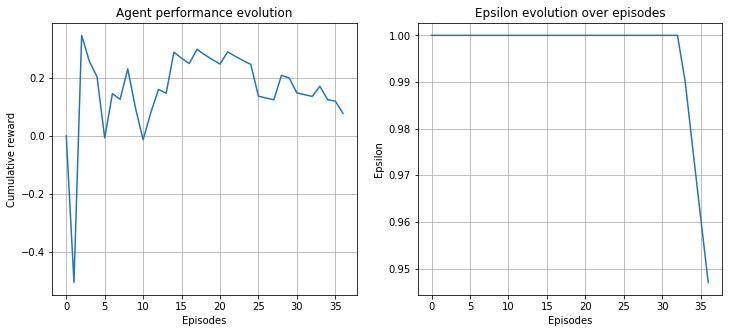

In [ ]:
#%%timeit
n_episodes = 1500
eps_decay=0.99995
eps_final=0.01
exploration_steps = 10000
tau = 3e-4
learning_rate = 1e-3
exp_replay_size = int(1e5)
update_every = 4
agent = QAgent(n_actions=n_actions, state_size=state_size, architecture=CNNArchitecture,
               epsilon_exp_decay=eps_decay, epsilon_final=eps_final, batch_size=64,
               initial_exploration_steps=exploration_steps, tau = tau,
               update_every=update_every,exp_replay_size=exp_replay_size)
scores = []
eps = []
for i in range(n_episodes):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.visual_observations[0]  
    done=False
    episodic_score=0
    while not done:
        action = agent.choose_action(state)

        env_info = env.step(int(action))[brain_name]
        reward = env_info.rewards[0]
        next_state = env_info.visual_observations[0]
        done = env_info.local_done[0] 

        agent.step(state=state, action=action, reward=reward, next_state=next_state)
        state = next_state
        episodic_score += reward
    eps.append(agent.epsilon)
    scores.append(episodic_score)
    if i % 100 == 0:
        torch.save(agent.neural_net.net.state_dict(), 'checkpoint.pth')
            
    clear_output(True)
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(ewma(scores))
    plt.grid()
    plt.xlabel("Episodes")
    plt.ylabel("Cumulative reward")
    plt.title("Agent performance evolution")
    plt.subplot(122)
    plt.plot(eps)
    plt.grid()
    plt.xlabel("Episodes")
    plt.ylabel("Epsilon")
    plt.title("Epsilon evolution over episodes")
    plt.show()
